
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Авторы материала: Юрий Кашницкий, программист-исследователь Mail.Ru Group, и Мария Сумарокова, старший эксперт по аналитике VimpelCom. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center>Домашнее задание № 3 (демо). <br>Деревья решений в игрушечной задаче и на данных Adult репозитория UCI

**В задании Вам предлагается разобраться с тем, как работает дерево решений, на игрушечном примере, затем обучить и настроить деревья и (при желании) случайный лес в задаче классификации на данных Adult репозитория UCI. Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/1bC3jNPH7XZUty_DaIvt0fPrsiS8YFkcpeBKHPSG0hw0/edit).**

Подключаем необходимые библиотеки

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
import collections

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Часть 1. Игрушечный набор данных "девушка в баре"

**Цель –  "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.**

**Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.**
<img src='../../img/toy_data.png'>

### Создание набора данных

In [9]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [10]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

**Обучающая выборка**

In [11]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,False,True,True,False,True,False,False,False,True
1,1,False,True,True,False,False,True,False,True,False
2,0,False,True,False,True,False,False,True,False,True
3,1,True,False,False,True,False,False,True,True,False
4,1,True,False,True,False,False,True,False,False,True
5,0,True,False,True,False,True,False,False,False,True
6,0,False,True,True,False,False,False,True,False,True


**Тестовая выборка**

In [12]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,False,True,False,True,False,True,False,True
1,False,True,True,False,True,False,True,False
2,True,False,True,False,False,True,False,True


In [13]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Алкоголь_в_напитке_нет,Внешность_приятная,Внешность_отталкивающая,Уровень_красноречия_высокий,Потраченные_деньги_много,Потраченные_деньги_мало,Алкоголь_в_напитке_да,Уровень_красноречия_средний
0,False,True,False,True,True,False,True,False
1,False,True,False,False,False,True,True,False
2,True,True,False,False,True,False,False,True
3,True,False,True,False,False,True,False,True
4,False,False,True,False,True,False,True,False
5,False,False,True,True,True,False,True,False
6,False,True,False,False,True,False,True,True


In [14]:
df_test

,Алкоголь_в_напитке_нет,Внешность_приятная,Внешность_отталкивающая,Уровень_красноречия_высокий,Потраченные_деньги_много,Потраченные_деньги_мало,Алкоголь_в_напитке_да,Уровень_красноречия_средний
0,True,True,False,False,True,False,False,True
1,False,True,False,True,False,True,True,False
2,False,False,True,False,True,False,True,True


**Постройте от руки (или в графическом редакторе) дерево решений для этого набора данных. Дополнительно (для желающих) – можете сделать отрисовку дерева и написать код для построения всего дерева.**

<font color='red'>Вопрос 1.</font> Какова энтропия начальной системы ($S_0$)? Под состояниями системы понимаем значения признака "Поедет" – 0 или 1 (то есть всего 2 состояния).

<font color='red'>Вопрос 2. </font> Рассмотрим разбиение обучающей выборки по признаку "Внешность\_приятная". Какова энтропия  $S_1$ левой группы, тех, у кого внешность приятная, и правой группы – $S_2$? Каков прирост информации  при данном разбиении (IG)? 

In [15]:
s0 = -4/7*np.log2(4/7) - 3/7*np.log2(3/7)
s0

np.float64(0.9852281360342515)

In [16]:
sys1 = df_train[df_train['Внешность_приятная'] == True]
sys2 = df_train[df_train['Внешность_приятная'] == False]

s1 = -3/4*np.log2(3/4) - 1/4*np.log2(1/4)
s2 = -1/3*np.log2(1/3) - 2/3*np.log2(2/3)

ig = s0 - (4/7)*s1 - (3/7)*s2
s1, s2, ig

(np.float64(0.8112781244591328),
 np.float64(0.9182958340544896),
 np.float64(0.12808527889139443))

**Постройте с помощью `sklearn` дерево решений, обучив его на обучающей выборке. Глубину можно не ограничивать.**

In [17]:
tree = DecisionTreeClassifier()
tree.fit(df_train, y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


**Дополнительно: отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.**

In [18]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot', feature_names=df_train.columns, filled=True, rounded=True, special_characters=True)

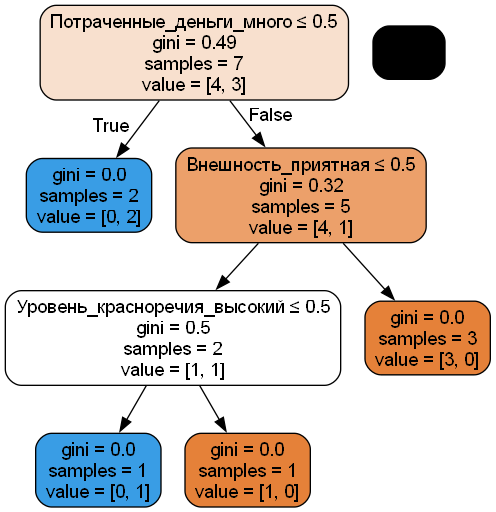

In [19]:
import pydotplus
graph = pydotplus.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
from IPython.display import Image
Image(filename='tree.png')

## Часть 2. Функции для расчета энтропии и прироста информации

Примерчик для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [20]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

![png](../../img/decision_tree3.png)

Дальше пусть шарики разбиваются на 2 группы
![png](../../img/decision_tree4.png)

In [21]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

**Реализуйте функцию для расчета энтропии Шеннона.**

In [22]:
def entropy(a_list): 
    return -sum([i/len(a_list) * np.log2(i/len(a_list)) for i in collections.Counter(a_list).values() if i > 0])

Проверка

In [23]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


<font color='red'>Вопрос 3.</font> Чему равна энтропия состояния, заданного списком `balls_left`?

<font color='red'>Вопрос 4.</font> Чему равна энтропия игральной кости с несмещенным центром тяжести?

In [28]:
# расчет прироста информации

def information_gain(root, left, right):
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    return entropy(root) - (len(left)/len(root) * entropy(left) + len(right)/len(root) * entropy(right))

<font color='red'>Вопрос 5.  </font> Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [29]:
information_gain(balls, balls_left, balls_right)

np.float64(0.16088518841412436)

In [ ]:
def best_feature_to_split(X, y):
    ''' Выводит прирост информации при разбиении по каждому признаку'''

    # Ваш код здесь
    pass

**Опционально:**

 - реализуйте алгоритм построения дерева за счет рекурсивного вызова функции `best_feature_to_split`
 - нарисуйте полученное дерево

## Часть 3. Набор данных "Adult"

**Описание набора:**

**[Набор](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) данных UCI Adult** (качать не надо, все есть в репозитории): классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более \$ 50 000 в год.

Описание признаков: 

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак  

**Считываем обучающую и тестовую выборки.**

In [99]:
data = pd.read_csv('./data/adult.data.csv', sep=',') 
data.rename(columns={'salary': 'Target'}, inplace=True)
data.Target = data.Target.astype('category').cat.codes

In [100]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.3, random_state=42)

In [101]:
data_test.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target
32476,35,Private,30673,12th,8,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,84,United-States,0
21100,24,Private,51973,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Female,0,0,20,United-States,0
27131,24,Private,442274,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Male,0,0,40,United-States,0
25526,56,Private,178353,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,1
21385,44,Private,198096,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,7688,0,40,United-States,1


**Первичный анализ данных.**

In [102]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,9769.0,NaN,NaN,NaN,38.613369,13.629008,17.0,28.0,37.0,48.0,90.0
workclass,9769,8,Private,6814,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,9769.0,NaN,NaN,NaN,189981.307708,105360.643228,14878.0,117860.0,178749.0,236769.0,1268339.0
education,9769,16,HS-grad,3182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education-num,9769.0,NaN,NaN,NaN,10.056096,2.559314,1.0,9.0,10.0,12.0,16.0
marital-status,9769,7,Married-civ-spouse,4452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,9769,15,Prof-specialty,1246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,9769,6,Husband,3907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,9769,5,White,8398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,9769,2,Male,6531,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_train['Target'].value_counts()

Target
0    17265
1     5527
Name: count, dtype: int64

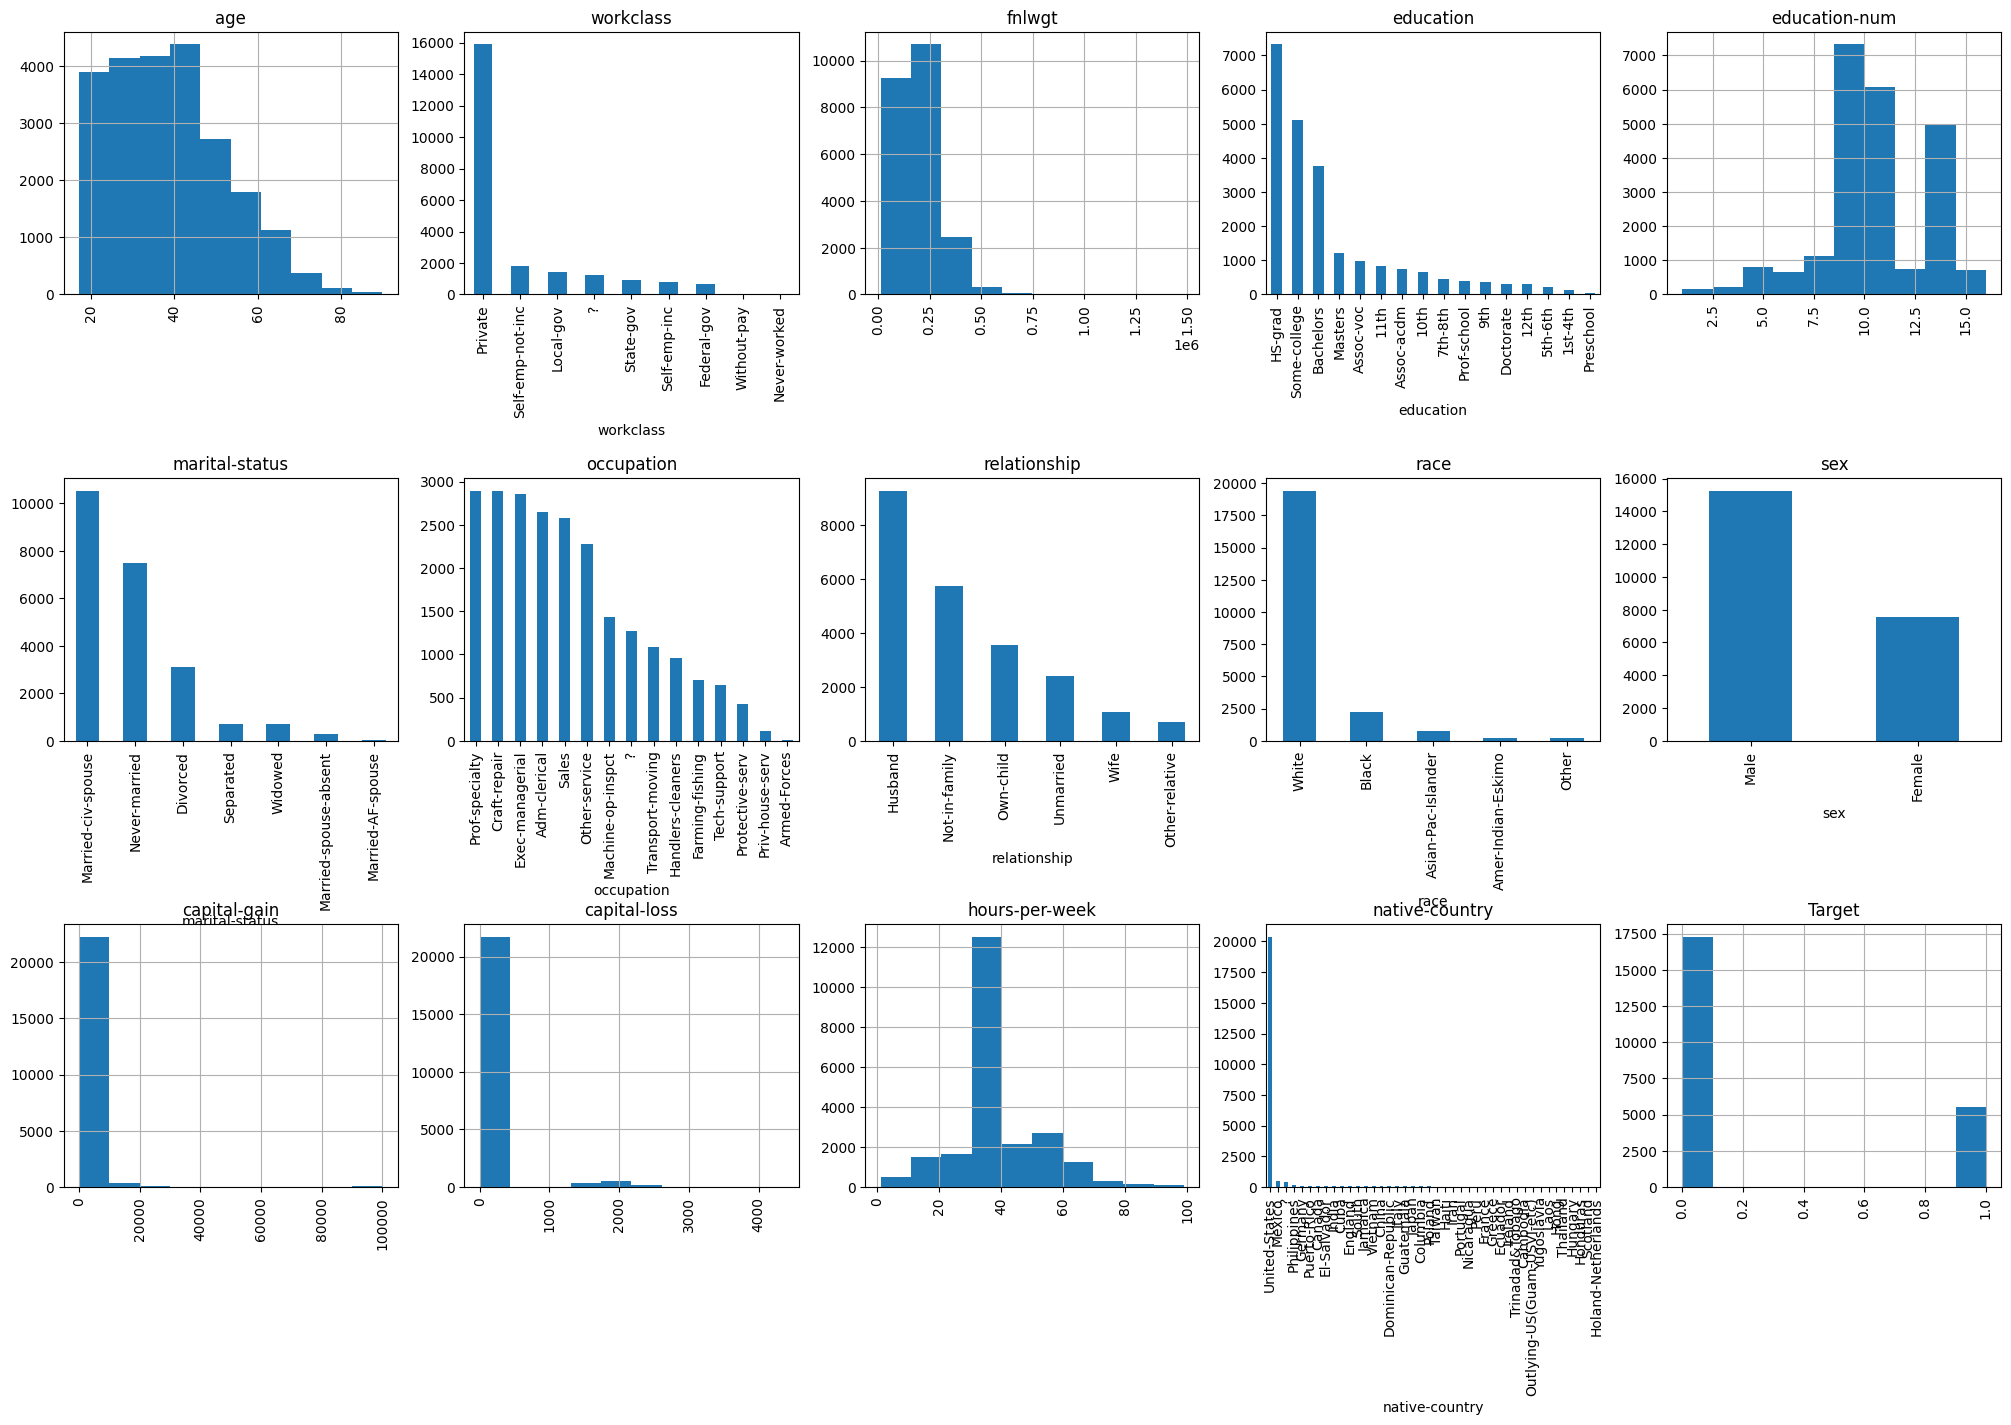

In [ ]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(int(rows), cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == object:
        data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Проверяем типы данных**

In [ ]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
Target              int8
dtype: object

In [60]:
data_test.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
Target              int8
dtype: object

**Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением**

In [ ]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data.columns 
                             if data[c].dtype.name == 'object']
numerical_columns_train = [c for c in data.columns 
                           if data[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
categorical_columns_train: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical_columns_test: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target']
numerical_columns_train: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target']


In [ ]:
# заполним пропуски

for c in categorical_columns_train:
    data[c] = data[c].fillna(data[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data[c].mode())
    
for c in numerical_columns_train:
    data[c] = data[c].fillna(data[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data[c].median())    

**Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.**

In [ ]:


data = pd.concat([data, pd.get_dummies(data['workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data['education'], prefix="Education"),
                      pd.get_dummies(data['marital-status'], prefix="Martial_Status"),
                      pd.get_dummies(data['occupation'], prefix="Occupation"),
                      pd.get_dummies(data['relationship'], prefix="Relationship"),
                      pd.get_dummies(data['race'], prefix="Race"),
                      pd.get_dummies(data['sex'], prefix="Sex"),
                      pd.get_dummies(data['native-country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['education'], prefix="Education"),
                      pd.get_dummies(data_test['marital-status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['race'], prefix="Race"),
                      pd.get_dummies(data_test['sex'], prefix="Sex"),
                      pd.get_dummies(data_test['native-country'], prefix="Country")],
                     axis=1)

In [ ]:
data_train.drop(['workclass', 'education', 'marital-status',
                 'occupation', 'relationship', 'race', 'sex', 'native-country'],
                axis=1, inplace=True)
data_test.drop(['workclass', 'education', 'marital-status',
                 'occupation', 'relationship', 'race', 'sex', 'native-country'],
               axis=1, inplace=True)

In [69]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,9769.0,NaN,NaN,NaN,38.613369,13.629008,17.0,28.0,37.0,48.0,90.0
fnlwgt,9769.0,NaN,NaN,NaN,189981.307708,105360.643228,14878.0,117860.0,178749.0,236769.0,1268339.0
education-num,9769.0,NaN,NaN,NaN,10.056096,2.559314,1.0,9.0,10.0,12.0,16.0
capital-gain,9769.0,NaN,NaN,NaN,1152.48572,7918.466846,0.0,0.0,0.0,0.0,99999.0
capital-loss,9769.0,NaN,NaN,NaN,82.248439,393.735311,0.0,0.0,0.0,0.0,4356.0
...,...,...,...,...,...,...,...,...,...,...,...
Country_Thailand,9769,2,False,9762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_Trinadad&Tobago,9769,2,False,9764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_United-States,9769,2,True,8807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_Vietnam,9769,2,False,9756,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
set(data.columns) - set(data_test.columns)

set()

In [ ]:
data.shape, data_test.shape

((22792, 211), (9769, 107))

**В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.**

In [76]:
data_test['Country_Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])
data_test['Workclass_Never-worked'] = np.zeros([data_test.shape[0], 1])

In [ ]:
set(data.columns) - set(data_test.columns)

set()

In [ ]:
data.head(2).T

,19749,1216
age,34,48
fnlwgt,56460,243631
education-num,9,10
capital-gain,0,7688
capital-loss,2179,0
...,...,...
Country_Thailand,False,False
Country_Trinadad&Tobago,False,False
Country_United-States,True,True
Country_Vietnam,False,False


In [90]:
data_test.head(2).T
data_test.drop(['Country_ Holand-Netherlands'], axis=1, inplace=True)

In [ ]:
X_train=data.drop(['Target'], axis=1)
y_train = data['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

In [ ]:
set(data.columns)

{'Country_?',
 'Country_Cambodia',
 'Country_Canada',
 'Country_China',
 'Country_Columbia',
 'Country_Cuba',
 'Country_Dominican-Republic',
 'Country_Ecuador',
 'Country_El-Salvador',
 'Country_England',
 'Country_France',
 'Country_Germany',
 'Country_Greece',
 'Country_Guatemala',
 'Country_Haiti',
 'Country_Holand-Netherlands',
 'Country_Honduras',
 'Country_Hong',
 'Country_Hungary',
 'Country_India',
 'Country_Iran',
 'Country_Ireland',
 'Country_Italy',
 'Country_Jamaica',
 'Country_Japan',
 'Country_Laos',
 'Country_Mexico',
 'Country_Nicaragua',
 'Country_Outlying-US(Guam-USVI-etc)',
 'Country_Peru',
 'Country_Philippines',
 'Country_Poland',
 'Country_Portugal',
 'Country_Puerto-Rico',
 'Country_Scotland',
 'Country_South',
 'Country_Taiwan',
 'Country_Thailand',
 'Country_Trinadad&Tobago',
 'Country_United-States',
 'Country_Vietnam',
 'Country_Yugoslavia',
 'Education_10th',
 'Education_11th',
 'Education_12th',
 'Education_1st-4th',
 'Education_5th-6th',
 'Education_7th-8t

In [94]:
set(data_test.columns)

{'Country_?',
 'Country_Cambodia',
 'Country_Canada',
 'Country_China',
 'Country_Columbia',
 'Country_Cuba',
 'Country_Dominican-Republic',
 'Country_Ecuador',
 'Country_El-Salvador',
 'Country_England',
 'Country_France',
 'Country_Germany',
 'Country_Greece',
 'Country_Guatemala',
 'Country_Haiti',
 'Country_Holand-Netherlands',
 'Country_Honduras',
 'Country_Hong',
 'Country_Hungary',
 'Country_India',
 'Country_Iran',
 'Country_Ireland',
 'Country_Italy',
 'Country_Jamaica',
 'Country_Japan',
 'Country_Laos',
 'Country_Mexico',
 'Country_Nicaragua',
 'Country_Outlying-US(Guam-USVI-etc)',
 'Country_Peru',
 'Country_Philippines',
 'Country_Poland',
 'Country_Portugal',
 'Country_Puerto-Rico',
 'Country_Scotland',
 'Country_South',
 'Country_Taiwan',
 'Country_Thailand',
 'Country_Trinadad&Tobago',
 'Country_United-States',
 'Country_Vietnam',
 'Country_Yugoslavia',
 'Education_10th',
 'Education_11th',
 'Education_12th',
 'Education_1st-4th',
 'Education_5th-6th',
 'Education_7th-8t

## 3.1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.**

In [108]:
data = pd.read_csv('./data/adult.data.csv', sep=',') 
data.rename(columns={'salary': 'Target'}, inplace=True)
data.Target = data.Target.astype('category').cat.codes

data_new = pd.concat([data, pd.get_dummies(data['workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data['education'], prefix="Education"),
                      pd.get_dummies(data['marital-status'], prefix="Martial_Status"),
                      pd.get_dummies(data['occupation'], prefix="Occupation"),
                      pd.get_dummies(data['relationship'], prefix="Relationship"),
                      pd.get_dummies(data['race'], prefix="Race"),
                      pd.get_dummies(data['sex'], prefix="Sex"),
                      pd.get_dummies(data['native-country'], prefix="Country")],
                     axis=1)
data_new.drop(['workclass', 'education', 'marital-status',
                 'occupation', 'relationship', 'race', 'sex', 'native-country'],
                axis=1, inplace=True)
data_new

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,Target,Workclass_?,Workclass_Federal-gov,Workclass_Local-gov,...,Country_Portugal,Country_Puerto-Rico,Country_Scotland,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States,Country_Vietnam,Country_Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32557,40,154374,9,0,0,40,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32558,58,151910,9,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32559,22,201490,9,0,0,20,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [109]:
data_train, data_test = train_test_split(data_new, test_size=0.3)
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

In [110]:
tree = DecisionTreeClassifier(random_state=17, max_depth=3)
tree.fit(X_train, y_train) # Ваш код здесь

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,17
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [111]:
tree_predictions = tree.predict(X_test) # Ваш код здесь

In [112]:
accuracy_score(y_test, tree_predictions) # Ваш код здесь

0.8466577950660252

<font color='red'>Вопрос 6.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

## 3.2. Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`. Проведите 5-кратную кросс-валидацию**

In [113]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5, n_jobs=-1) # Ваш код здесь                      

locally_best_tree.fit(X_train, y_train) # Ваш код здесь

,estimator,DecisionTreeC...ndom_state=17)
,param_grid,"{'max_depth': range(2, 11)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [114]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 8}
Best cross validaton score 0.854378943289585


**Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.**

In [117]:
tuned_tree = DecisionTreeClassifier(max_depth=9)# Ваш код здесь
tuned_tree.fit(X_train, y_train) # Ваш код здесь
tuned_tree_predictions = tuned_tree.predict(X_test) # Ваш код здесь
accuracy_score(y_test, tuned_tree_predictions) # Ваш код здесь

0.8557682464940116

<font color='red'>Вопрос 7.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

## 3.3. Случайный лес без настройки параметров  (опционально)¶

**Немного забежим вперед и попробуем в нашей задаче случайный лес. Пока можно его себе представлять, как куча деревьев решений, обученных на немного разных подвыборках исходной обучающей выборки, причем эта куча деревьев обычно работает существенно лучше, чем отдельные деревья. **

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`), число деревьев сделайте равным ста, а `random_state` = 17.**

In [118]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)# Ваш код здесь
rf.fit(X_train, y_train) # Ваш код здесь

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [119]:
forest_predictions = rf.predict(X_test) # Ваш код здесь

In [120]:
accuracy_score(y_test, forest_predictions) # Ваш код здесь

0.860067560651039

## 3.4. Случайный лес с настройкой параметров  (опционально)

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`). Максимальную глубину и максимальное число признаков для каждого дерева настройте с помощью GridSearchCV.**

In [122]:
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 10)}

locally_best_forest = GridSearchCV(RandomForestClassifier(n_estimators=100, random_state=17), forest_params, cv=5, n_jobs=-1) # Ваш код здесь

locally_best_forest.fit(X_train, y_train) # Ваш код здесь

,estimator,RandomForestC...ndom_state=17)
,param_grid,"{'max_depth': range(10, 21), 'max_features': range(5, 105, 10)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [124]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 17, 'max_features': 25}
Best cross validaton score 0.8626713324525472


**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [125]:
tuned_forest_predictions = locally_best_forest.predict(X_test) # Ваш код здесь
accuracy_score(y_test, tuned_forest_predictions) # Ваш код здесь

0.8683590950967346